# Shear Likelihood 2.1

### Preparing necessary libraries

In [1]:
import os
import sys
import gi

gi.require_version('NumCosmo', '1.0')
gi.require_version('NumCosmoMath', '1.0')
from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

os.environ['CLMM_MODELING_BACKEND'] = 'nc'

__name__ = "NcContext"

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
import matplotlib.pyplot as plt
import numpy as np
import time
from datetime import timedelta
from astropy import units
from numpy import random
plt.rcParams['font.family']=['gothambook','gotham','gotham-book','serif']

import clmm.dataops as da
import clmm.galaxycluster as gc
import clmm.theory as theory
from clmm import Cosmology
from clmm.support import mock_data as mock
from clmm.utils import convert_units
from scipy.stats import kstest

### Creating mock data

In [2]:
np.random.seed(11)

cosmo = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)

cluster_m     = 1.e15
logm = np.log(cluster_m)/np.log(10)
cluster_z     = 0.4
concentration = 4
ngals         = 10000
Delta         = 200
cluster_ra    = 0.0
cluster_dec   = 0.0

shapenoise = 1e-3

ideal_data   = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, 0.8, zsrc_min = cluster_z + 0.1, shapenoise=shapenoise, ngals=ngals, cluster_ra=cluster_ra, cluster_dec=cluster_dec)
ideal_data_z = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo,'chang13', zsrc_min = cluster_z + 0.1, shapenoise=shapenoise, ngals=ngals, cluster_ra=cluster_ra, cluster_dec=cluster_dec)
noisy_data_z = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, 'chang13', zsrc_min = cluster_z + 0.1, shapenoise=shapenoise, photoz_sigma_unscaled=0.05, ngals=ngals, cluster_ra=cluster_ra, cluster_dec=cluster_dec)

gc_ideal   = clmm.GalaxyCluster("CL_ideal", cluster_ra, cluster_dec, cluster_z, ideal_data)
gc_ideal_z = clmm.GalaxyCluster("CL_ideal_z", cluster_ra, cluster_dec, cluster_z, ideal_data_z)
gc_noisy_z = clmm.GalaxyCluster("CL_noisy_z", cluster_ra, cluster_dec, cluster_z, noisy_data_z)


### Calculating observables

In [3]:
theta_ideal, gt_ideal, gx_ideal       = gc_ideal.compute_tangential_and_cross_components(geometry="flat")
theta_ideal_z, gt_ideal_z, gx_ideal_z = gc_ideal_z.compute_tangential_and_cross_components(geometry="flat")
theta_noisy_z, gt_noisy_z, gx_noisy_z = gc_noisy_z.compute_tangential_and_cross_components(geometry="flat")

In [4]:
radius_ideal   = convert_units(gc_ideal.galcat['theta'], 'radians', 'Mpc', redshift=gc_ideal.z, cosmo=cosmo)
radius_ideal_z = convert_units(gc_ideal_z.galcat['theta'], 'radians', 'Mpc', redshift=gc_ideal_z.z, cosmo=cosmo)
radius_noisy_z = convert_units(gc_noisy_z.galcat['theta'], 'radians', 'Mpc', redshift=gc_noisy_z.z, cosmo=cosmo)

### Calculating theoretical lensing shear for each source

In [5]:
gt_th_ideal   = clmm.compute_reduced_tangential_shear(radius_ideal, cluster_m, concentration, gc_ideal.z, gc_ideal.galcat['z'], cosmo, delta_mdef=200, halo_profile_model='nfw')
gt_th_ideal_z = clmm.compute_reduced_tangential_shear(radius_ideal_z, cluster_m, concentration, gc_ideal_z.z, gc_ideal_z.galcat['z'], cosmo, delta_mdef=200, halo_profile_model='nfw')
gt_th_noisy_z = clmm.compute_reduced_tangential_shear(radius_noisy_z, cluster_m, concentration, gc_noisy_z.z, gc_noisy_z.galcat['z'], cosmo, delta_mdef=200, halo_profile_model='nfw')

### Calculating $P_{KDE}(g^{L,i}_t)$

In [6]:
gt_th_ideal_kde     = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.AUTO, 1, 0.001)
gt_th_ideal_kde_rot = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.ROT, 1, 0.001)

for gt in gt_th_ideal:
    gt_th_ideal_kde.add_obs(gt)
    gt_th_ideal_kde_rot.add_obs(gt)

gt_th_ideal_kde.prepare()
gt_th_ideal_kde_rot.prepare()




gt_th_ideal_z_kde     = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.AUTO, 1, 0.001)
gt_th_ideal_z_kde_rot = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.ROT, 1, 0.001)

for gt in gt_th_ideal_z:
    gt_th_ideal_z_kde.add_obs(gt)
    gt_th_ideal_z_kde_rot.add_obs(gt)

gt_th_ideal_z_kde.prepare()
gt_th_ideal_z_kde_rot.prepare()




gt_th_noisy_z_kde     = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.AUTO, 1, 0.001)
gt_th_noisy_z_kde_rot = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.ROT, 1, 0.001)

for gt in gt_th_noisy_z:
    if gt != 0:
        gt_th_noisy_z_kde.add_obs(gt)
        gt_th_noisy_z_kde_rot.add_obs(gt)

gt_th_noisy_z_kde.prepare()
gt_th_noisy_z_kde_rot.prepare()

### Plotting $P_{KDE}(g^{L,i}_t)$

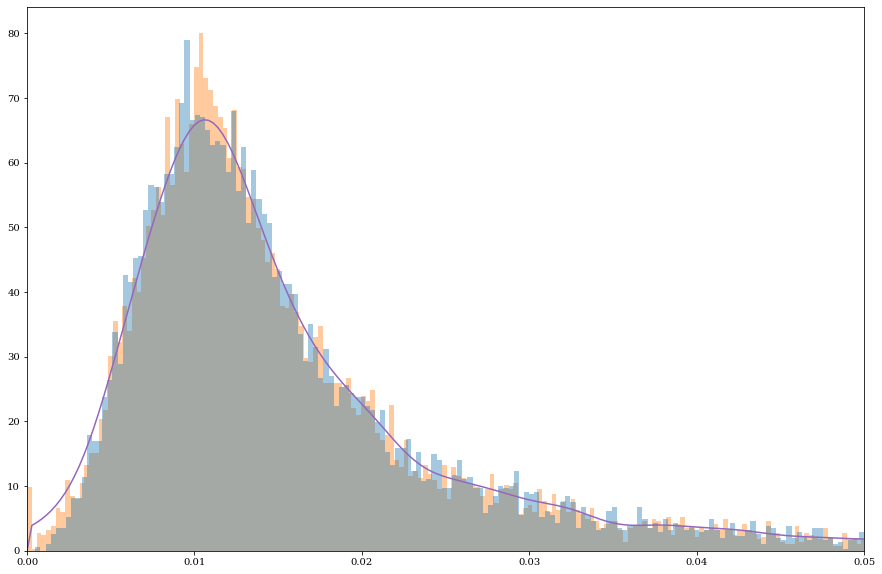

In [13]:
# fig, ax = plt.subplots(3, 1, figsize=(15,20), facecolor="white")

# for gt_th, gt_obs, kde, kde_rot, i in zip([gt_th_ideal, gt_th_ideal_z, gt_th_noisy_z], [gt_ideal, gt_ideal_z, gt_noisy_z], [gt_th_ideal_kde, gt_th_ideal_z_kde, gt_th_noisy_z_kde], [gt_th_ideal_kde_rot, gt_th_ideal_z_kde_rot, gt_th_noisy_z_kde_rot], range(3)):

#     gt_min, gt_max = min(gt_th), max(gt_th)

#     x = np.linspace(gt_min, gt_max, num=1000)
#     y = [kde.eval_p(x_i) for x_i in x]
#     z = [kde_rot.eval_p(x_i) for x_i in x]
    
#     ax[i].hist(gt_th, bins=1000, density=True, alpha=0.4, color='tab:orange')
#     ax[i].hist(gt_obs, bins=1000, density=True, alpha=0.4, color='tab:blue')
#     ax[i].plot(x, y, color='tab:red')
#     ax[i].plot(x, z, color='tab:purple')
#     # ax[i].set_xscale('log')
#     # ax[i].set_xlim(0, 0.02)

    
fig, ax = plt.subplots(1, 1, figsize=(15,10), facecolor="white")

for gt_th, gt_obs, kde, kde_rot, i in zip([gt_th_noisy_z], [gt_noisy_z], [gt_th_noisy_z_kde], [gt_th_noisy_z_kde_rot], range(1)):    
    gt_min, gt_max = min(gt_th), max(gt_th)

    x = np.linspace(gt_min, gt_max, num=1000)
    y = [kde.eval_p(x_i) for x_i in x]
    z = [kde_rot.eval_p(x_i) for x_i in x]

    ax.hist(gt_th, bins=1000, density=True, alpha=0.4, color='tab:orange')
    ax.hist(gt_obs, bins=1000, density=True, alpha=0.4, color='tab:blue')
    # ax.plot(x, y, color='tab:red')
    ax.plot(x, z, color='tab:purple')
    # ax[i].set_xscale('log')
    # ax[i].set_xlim(0, 0.02)
    
    # ax.hist(gt_th, bins=1000, density=True, alpha=0.4, color='tab:orange')
    # ax.hist(gt_obs, bins=1000, density=True, alpha=0.4, color='tab:blue')
    # ax.plot(x, y, color='tab:red')
    # ax.plot(x, z, color='tab:purple')
    # # ax.set_xscale('log')
    ax.set_xlim(0, 0.05)


### Updating the KDE for likelihood

In [8]:
# for gt_th, gt_obs in zip(gt_th_noisy_z, gt_noisy_z):
#     if gt_th != 0:
#         gt_th_noisy_z_kde.add_obs(gt-gt_obs)
#         gt_th_noisy_z_kde_rot.add_obs(gt-gt_obs)

# gt_th_noisy_z_kde.prepare()
# gt_th_noisy_z_kde_rot.prepare()

In [9]:
# import scipy.integrate as integrate

# result = integrate.quad(gt_th_noisy_z_kde.eval_p, -np.inf, np.inf)

In [10]:
def shear_log_likelihood(logm, gc, radius, shapenoise, cosmo, sigma=1, concentration=4, delta=200, model='nfw'):

    m = float(10.**logm)
    gt_th = clmm.compute_reduced_tangential_shear(radius, m, concentration, gc.z, gc.galcat['z'], cosmo, delta_mdef=200, halo_profile_model='nfw')
    gt_obs = gc.galcat['et']
    
    gt_th_kde_rot = Ncm.StatsDist1dEPDF.new_full(2000, Ncm.StatsDist1dEPDFBw.ROT, 1, 0.001)

    for gt in gt_th:
        if gt != 0:
            gt_th_kde_rot.add_obs(gt)
            

    gt_th_kde_rot.prepare()

    log_likelihood = 0

    for gt in gt_obs:
        log_likelihood += np.log(gt_th_kde_rot.eval_p(gt))
    
    return -2*log_likelihood


In [11]:
from clmm.support.sampler import samplers

logm_0 = random.uniform(13., 17., 1)[0]

logm_est = samplers['basinhopping'](shear_log_likelihood, logm_0, minimizer_kwargs={'args':(gc_noisy_z, radius, shapenoise, cosmo)})

print(10.**logm_est)

NameError: name 'radius' is not defined

In [ ]:
def shear_log_likelihood_2(logm, gc, radius, shapenoise, cosmo, sigma=1, concentration=4, delta=200, model='nfw'):

    m = float(10.**logm)
    gt_th = clmm.compute_reduced_tangential_shear(radius, m, concentration, gc.z, gc.galcat['z'], cosmo, delta_mdef=200, halo_profile_model='nfw')
    gt_obs = gc.galcat['et']
    
    gt_th_kde_rot = Ncm.StatsDist1dEPDF.new_full(2000, Ncm.StatsDist1dEPDFBw.ROT, 1, 0.001)

    for gt in gt_th:
        if gt != 0:
            gt_th_kde_rot.add_obs(gt)
            

    gt_th_kde_rot.prepare()

    log_likelihood = 0

    for gt in gt_obs:
        if gt != 0:
            gt_th_kde_rot.add_obs(gt)
        log_likelihood += np.log(gt_th_kde_rot.eval_p(gt))
    
    return -2*log_likelihood


logm_est = samplers['basinhopping'](shear_log_likelihood_2, logm_0, minimizer_kwargs={'args':(gc_noisy_z, radius, shapenoise, cosmo)})

print(10.**logm_est)


(process:40450): NUMCOSMO-WARNING **: 04:50:30.614: ncm_ode_spline_prepare: system has saturated at `  -0.00628256340673428' before attaining the required final value `      15.1843095038416'.

(process:40450): NUMCOSMO-WARNING **: 04:50:30.854: ncm_ode_spline_prepare: system has saturated at `  -0.00628256432985106' before attaining the required final value `      15.1843245003122'.

(process:40450): NUMCOSMO-WARNING **: 04:50:31.676: ncm_ode_spline_prepare: system has saturated at `  -0.00629022290645366' before attaining the required final value `      15.4588615284048'.

(process:40450): NUMCOSMO-WARNING **: 04:50:31.932: ncm_ode_spline_prepare: system has saturated at `  -0.00629022389354825' before attaining the required final value `      15.4588770696675'.

(process:40450): NUMCOSMO-WARNING **: 04:50:32.192: ncm_ode_spline_prepare: system has saturated at `  -0.00628500632800492' before attaining the required final value `      15.2238797159189'.

(process:40450): NUMCOSMO-WAR

[4.06410411e+15]


In [ ]:
def shear_log_likelihood_3(logm, gc, radius, shapenoise, cosmo, sigma=1, concentration=4, delta=200, model='nfw'):

    m = float(10.**logm)
    gt_th = clmm.compute_reduced_tangential_shear(radius, m, concentration, gc.z, gc.galcat['z'], cosmo, delta_mdef=200, halo_profile_model='nfw')
    gt_obs = gc.galcat['et']
    
    gt_th_kde_rot = Ncm.StatsDist1dEPDF.new_full(2000, Ncm.StatsDist1dEPDFBw.ROT, 1, 0.001)

    for gt in gt_th:
        if gt != 0:
            gt_th_kde_rot.add_obs(gt)
            

    gt_th_kde_rot.prepare()

    log_likelihood = 0

    for gt in gt_obs:
        for gt_l in gt_th:
            if gt-gt_l > 0:
                gt_th_kde_rot.add_obs(gt-gt_l)
        log_likelihood += np.log(gt_th_kde_rot.eval_p(gt))
    
    return -2*log_likelihood


logm_est = samplers['basinhopping'](shear_log_likelihood_3, logm_0, minimizer_kwargs={'args':(gc_noisy_z, radius, shapenoise, cosmo)})

print(10.**logm_est)


(process:40450): NUMCOSMO-WARNING **: 06:33:42.023: ncm_ode_spline_prepare: system has saturated at `     -5.37182654573114' before attaining the required final value `      81.0019033941353'.

(process:40450): NUMCOSMO-WARNING **: 06:33:59.679: ncm_ode_spline_prepare: system has saturated at `     -5.37182484730513' before attaining the required final value `      81.0022608902524'.

(process:40450): NUMCOSMO-WARNING **: 06:34:17.987: ncm_ode_spline_prepare: system has saturated at `     0.581815445666055' before attaining the required final value `      1.28861338298578'.

(process:40450): NUMCOSMO-WARNING **: 06:34:48.685: ncm_ode_spline_prepare: system has saturated at `      0.58181547545903' before attaining the required final value `      1.28861353388613'.

(process:40450): NUMCOSMO-WARNING **: 06:35:20.315: ncm_ode_spline_prepare: system has saturated at `     0.560322345675974' before attaining the required final value `      1.18564192835827'.

(process:40450): NUMCOSMO-WAR

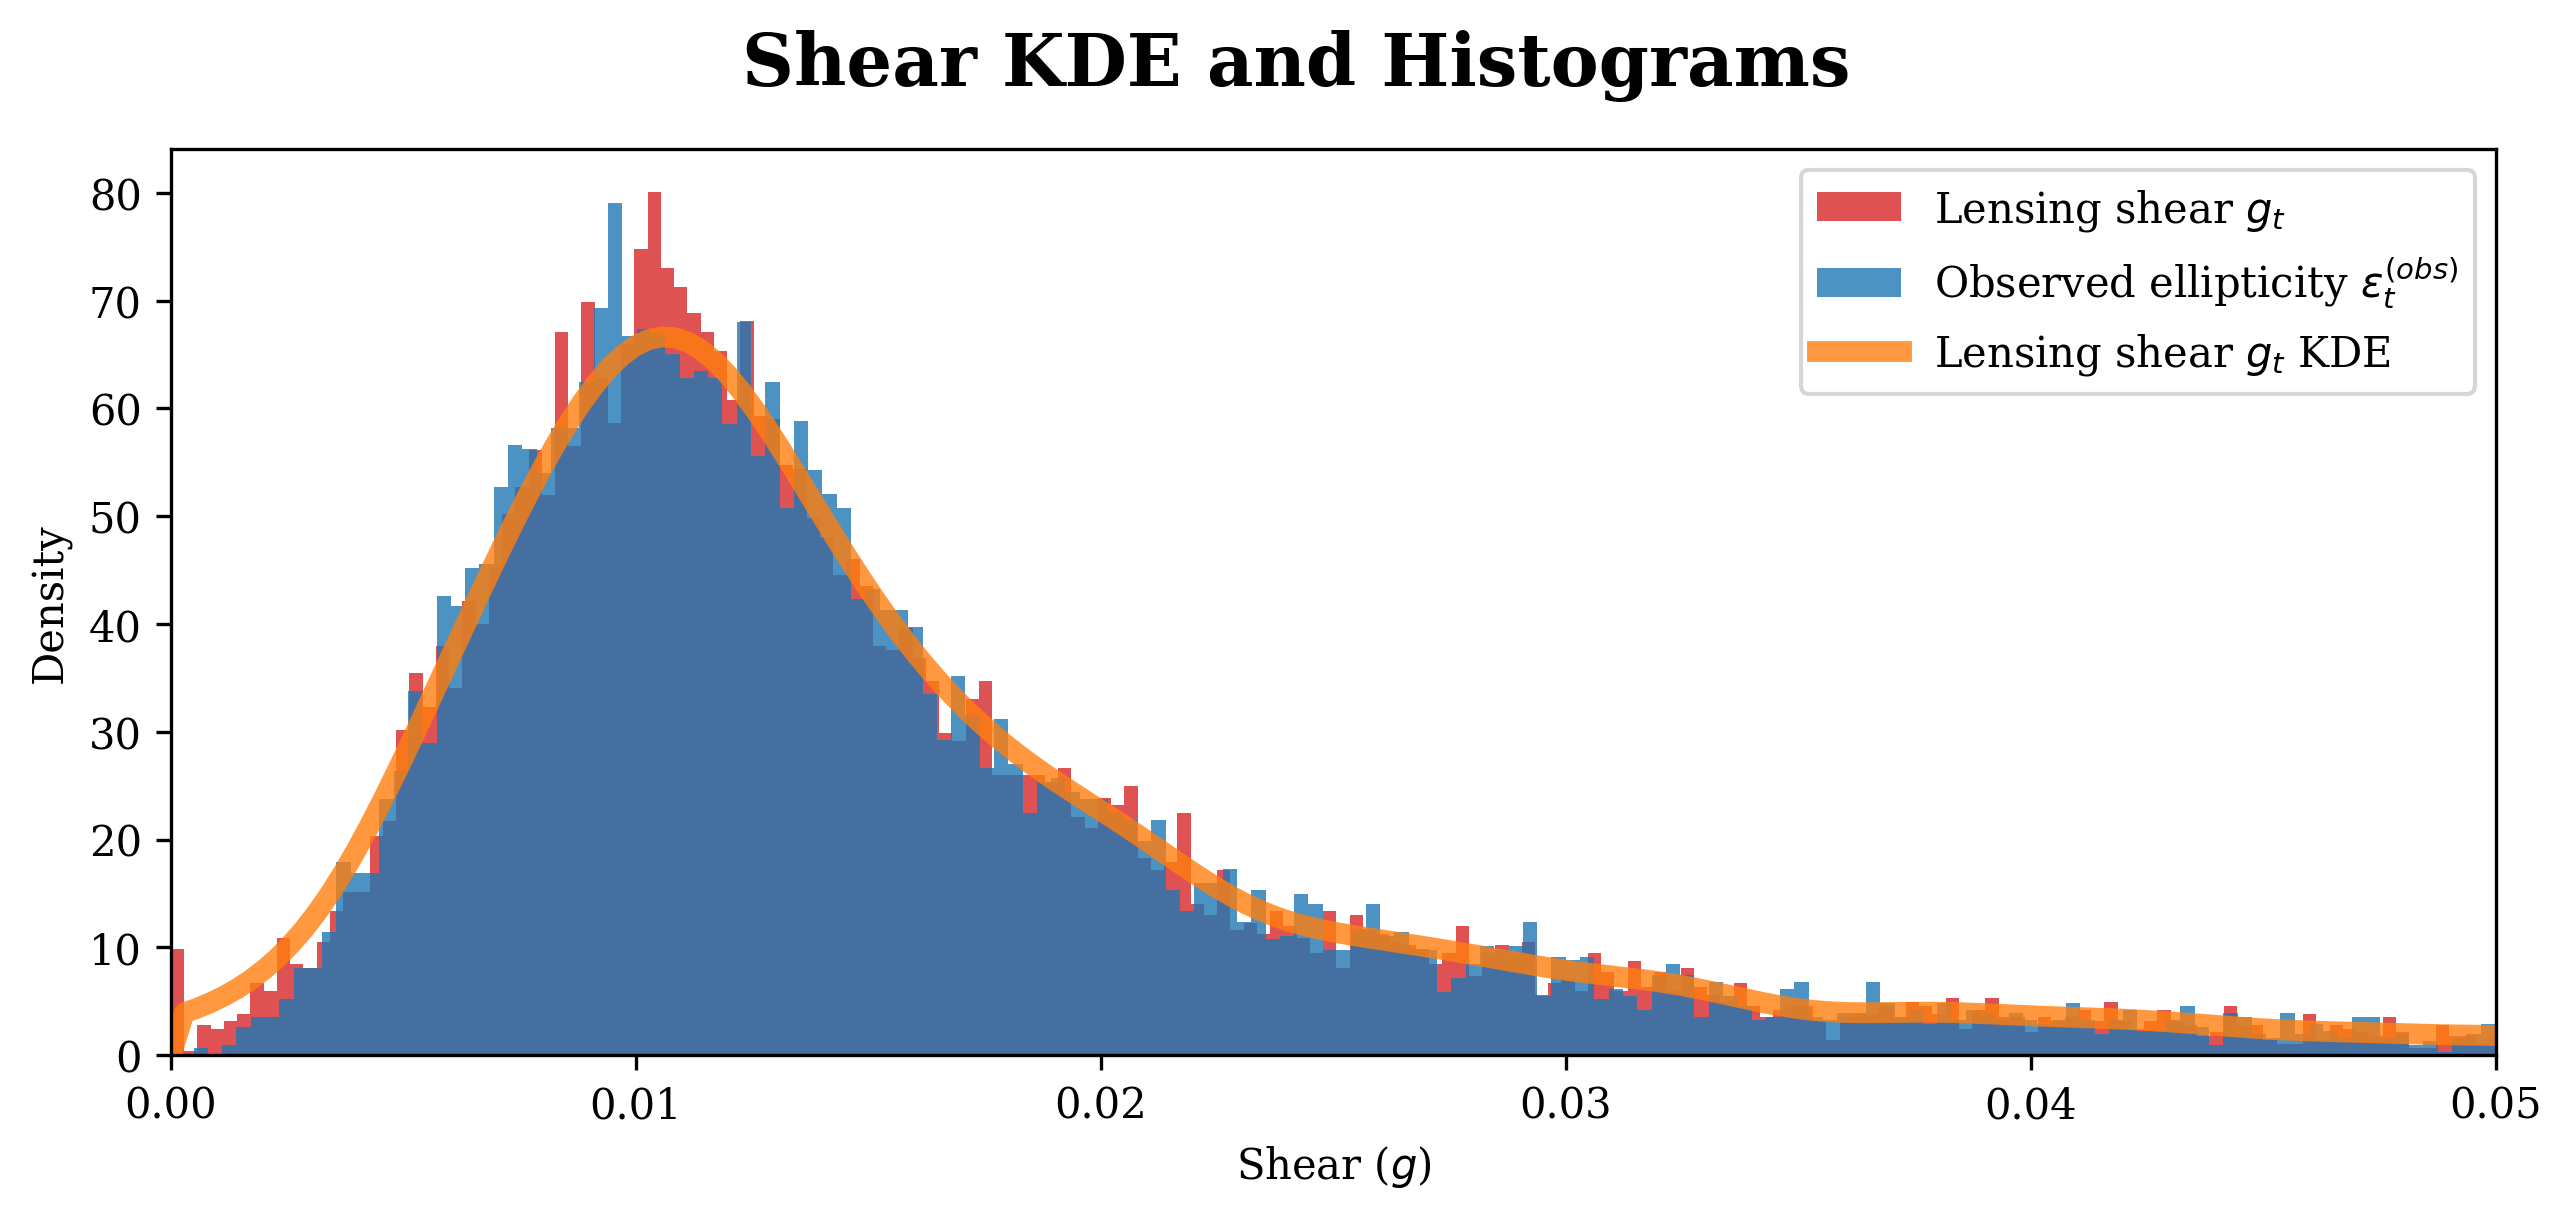

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10,4), dpi=300)
fig.suptitle(f'Shear KDE and Histograms', size='xx-large', weight='bold')

for gt_th, gt_obs, kde, kde_rot, i in zip([gt_th_noisy_z], [gt_noisy_z], [gt_th_noisy_z_kde], [gt_th_noisy_z_kde_rot], range(1)):    
    gt_min, gt_max = min(gt_th), max(gt_th)

    x = np.linspace(gt_min, gt_max, num=1000)
    y = [kde_rot.eval_p(x_i) for x_i in x]

    ax.hist(gt_th, bins=1000, density=True, alpha=0.8, color='tab:red', label=f'Lensing shear $g_t$')
    ax.hist(gt_obs, bins=1000, density=True, alpha=0.8, color='tab:blue', label=f'Observed ellipticity $\\epsilon^{{(obs)}}_t$')
    ax.plot(x, y, color='tab:orange', linestyle='-', alpha=0.8, linewidth=5, label=f'Lensing shear $g_t$ KDE')
    # ax.set_title(f'Comparing the distributions of $g_t$ and $g_t^L$ and its KDE', weight='bold')
    ax.set_ylabel(f'Density')
    ax.set_xlabel(f'Shear ($g$)')
    ax.legend()

    ax.set_xlim(0, 0.05)
fig.savefig("Plots/shear_kde.png")